In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import gammainc

In [24]:
font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [49]:
# parameter choices 

# estimated parameters
alpha = 0.5 # base resuscitation rate
beta = 1.0 # acceleration of resuscitation S(t) = α e^{βt}
X_H = 0.8 # growth rate of healthy cells
X_D = 0.4 # growth rate of damaged cells
phi_DH = 0.3 # probability damaged -> healthy at division

# partitioning probabilities from persisters -- from Fang & Allison paper
sigma_PF = 0.64 # P -> F 
sigma_PD = 0.32 # P -> D 
sigma_PH = 0.04 # P -> H 
Sigma_sigma = sigma_PF + sigma_PD + sigma_PH

# analytical equation expressions
a = X_D * (1.0 - phi_DH)
c = alpha * Sigma_sigma / beta
q_D = 1.0 - a / beta
q_H = 1.0 - X_H / beta
k = X_D * phi_DH / (X_H - a)
B = sigma_PH + k * sigma_PD

In [50]:
def lower_incomplete_gamma(s, x):
    return float(gammainc(s, 0, x))

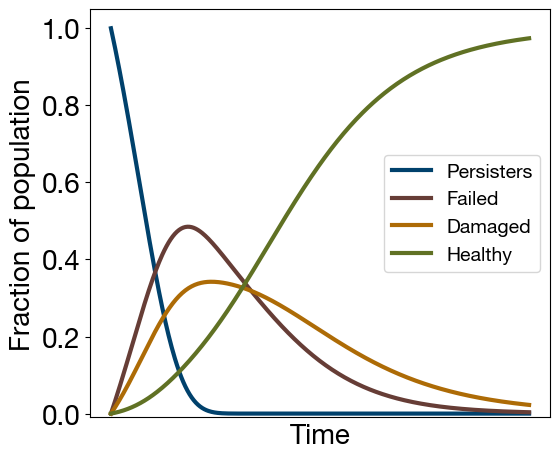

In [57]:
# initialize to all persisters
nP0 = 1.0  
nF0 = 0.0
nD0 = 0.0
nH0 = 0.0

t_vals = np.linspace(0.0, 10.0, 400)

nP_vals, nF_vals, nD_vals, nH_vals = [], [], [], []

# loop to compute population fractions over time 
for t in t_vals:
    nP_t = nP0 * np.exp(-c * (np.exp(beta * t) - 1.0))

    nF_t = nF0 + (sigma_PF / Sigma_sigma) * (nP0 - nP_t)

    ce_bt = c * np.exp(beta * t)

    term_D = lower_incomplete_gamma(q_D, ce_bt) - lower_incomplete_gamma(q_D, c)
    nD_t = np.exp(a * t) * (
        nD0
        + (alpha * sigma_PD * nP0 / beta)
        * np.exp(c)
        * (c ** (-q_D))
        * term_D
    )

    term_H = lower_incomplete_gamma(q_H, ce_bt) - lower_incomplete_gamma(q_H, c)
    nH_t = (
        np.exp(X_H * t)
        * (
            nH0
            + k * nD0
            + (alpha * B * nP0 / beta)
            * np.exp(c)
            * (c ** (-q_H))
            * term_H
        )
        - k
        * np.exp(a * t)
        * (
            nD0
            + (alpha * sigma_PD * nP0 / beta)
            * np.exp(c)
            * (c ** (-q_D))
            * term_D
        )
    )

    nP_vals.append(nP_t)
    nF_vals.append(nF_t)
    nD_vals.append(nD_t)
    nH_vals.append(nH_t)

nP_vals = np.array(nP_vals, dtype=float)
nF_vals = np.array(nF_vals, dtype=float)
nD_vals = np.array(nD_vals, dtype=float)
nH_vals = np.array(nH_vals, dtype=float)

# normalize by total population
N_tot = nP_vals + nF_vals + nD_vals + nH_vals
pP = nP_vals / N_tot
pF = nF_vals / N_tot
pD = nD_vals / N_tot
pH = nH_vals / N_tot

# plot 
plt.figure(figsize=(6, 5))
plt.plot(t_vals, pP, label="Persisters", linewidth=3, color="#00416c")
plt.plot(t_vals, pF, label="Failed", linewidth=3, color="#663d36")  
plt.plot(t_vals, pD, label="Damaged", linewidth=3, color="#ad6b06") 
plt.plot(t_vals, pH, label="Healthy", linewidth=3, color="#607124") 

plt.xlabel("Time")
plt.ylabel("Fraction of population")
plt.xticks([])
plt.ylim(-0.01, 1.05)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('/Users/asapp/Documents/VAST/r4_figs/persister_fractions.pdf')
plt.show()
